In [1]:

from __future__ import unicode_literals, print_function, division

from io import open
import unicodedata
import string
import re
import random

import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv('./data/en_train.csv',encoding='utf-8')

In [3]:
df = df[df['class']=='DATE']

In [154]:
df.head(30)

,sentence_id,token_id,class,before,after
10,1,0,DATE,2006,two thousand six
51,3,7,DATE,2007,two thousand seven
80,5,0,DATE,2008,two thousand eight
111,8,1,DATE,4 March 2014,the fourth of march twenty fourteen
147,11,1,DATE,"April 10, 2013",april tenth twenty thirteen
151,12,2,DATE,7 August 2007,the seventh of august two thousand seven
158,14,1,DATE,1987,nineteen eighty seven
211,18,12,DATE,1996,nineteen ninety six
256,22,1,DATE,22 September 2015,the twenty second of september twenty fifteen
367,29,2,DATE,"November 4, 2014",november fourth twenty fourteen


In [5]:
MAX_LENGTH = df.after.str.len().max()

In [6]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "SOS", 1: "EOS"}
        self.n_chars = 2  # Count SOS and EOS

    def add_sentence(self, sentence):
        for char in sentence:
            self.add_char(char)

    def add_char(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

In [7]:
def readLangs(df,lang1, lang2, reverse=False):
    pairs = [[a,b] for b,a in zip(df[lang1],df[lang2])]
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
def prepareData(df,lang1, lang2, reverse=False):
    MAX_LENGTH = df[lang2].str.len().max()
    input_lang, output_lang, pairs = readLangs(df,lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting chars...")
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])
    print("Counted chars:")
    print(input_lang.name, input_lang.n_chars)
    print(output_lang.name, output_lang.n_chars)
    return input_lang, output_lang, pairs

In [9]:
input_lang, output_lang, pairs = prepareData(df,'before', 'after', True)
print(random.choice(pairs))

Read 258348 sentence pairs
Counting chars...
Counted chars:
after 62
before 26
['1937', 'nineteen thirty seven']


In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size) # embedding_size (vocab_size), embedding_dim
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.char2index[char] for char in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [13]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [14]:
######################################################################
# This is a helper function to print time elapsed and estimated time
# remaining given the current time and progress %.
#

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


In [16]:

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_chars = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_chars.append('<EOS>')
                break
            else:
                decoded_chars.append(output_lang.index2char[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_chars, decoder_attentions[:di + 1]


In [241]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

5m 4s (- 45m 37s) (5000 10%) 1.2282
10m 27s (- 41m 51s) (10000 20%) 0.5710
15m 45s (- 36m 45s) (15000 30%) 0.3557
21m 4s (- 31m 36s) (20000 40%) 0.2314
26m 40s (- 26m 40s) (25000 50%) 0.2284
31m 58s (- 21m 19s) (30000 60%) 0.2077
37m 22s (- 16m 1s) (35000 70%) 0.1454
42m 46s (- 10m 41s) (40000 80%) 0.1503
48m 11s (- 5m 21s) (45000 90%) 0.1153
53m 37s (- 0m 0s) (50000 100%) 0.1268


<Figure size 432x288 with 0 Axes>

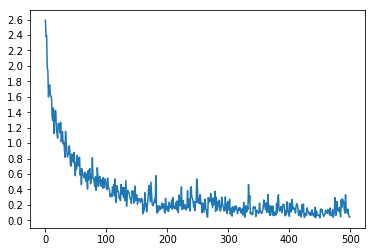

In [19]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_chars, hidden_size).to(device) # Size of the vocabulary, i.e. maximum integer index + 1.
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_chars, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 50000, print_every=5000)

5m 25s (- 48m 52s) (5000 10%) 0.0639
11m 8s (- 44m 35s) (10000 20%) 0.0441
16m 44s (- 39m 4s) (15000 30%) 0.0466
22m 17s (- 33m 25s) (20000 40%) 0.0400
27m 45s (- 27m 45s) (25000 50%) 0.0363
33m 26s (- 22m 17s) (30000 60%) 0.0423
38m 59s (- 16m 42s) (35000 70%) 0.0350
44m 37s (- 11m 9s) (40000 80%) 0.0289
50m 16s (- 5m 35s) (45000 90%) 0.0304
55m 52s (- 0m 0s) (50000 100%) 0.0293


<Figure size 432x288 with 0 Axes>

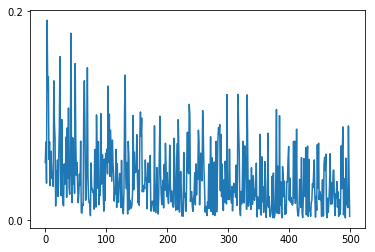

In [240]:
trainIters(encoder1, attn_decoder1, 50000, print_every=5000,learning_rate=0.005)

In [242]:
evaluateRandomly(encoder1, attn_decoder1)

> 1919
= nineteen nineteen
< nineteen nineteen<EOS>

> 1958
= nineteen fifty eight
< nineteen fifty eight<EOS>

> December 19, 2000
= december nineteenth two thousand
< december nineteenth two thousand<EOS>

> October 2009
= october two thousand nine
< october two thousand nine<EOS>

> 1976
= nineteen seventy six
< nineteen seventy six<EOS>

> 2009
= two thousand nine
< two thousand nine<EOS>

> 1995
= nineteen ninety five
< nineteen ninety five<EOS>

> 1985
= nineteen eighty five
< nineteen eighty five<EOS>

> 8 April 2010
= the eighth of april twenty ten
< the eighth of april twenty ten<EOS>

> 1976
= nineteen seventy six
< nineteen seventy six<EOS>



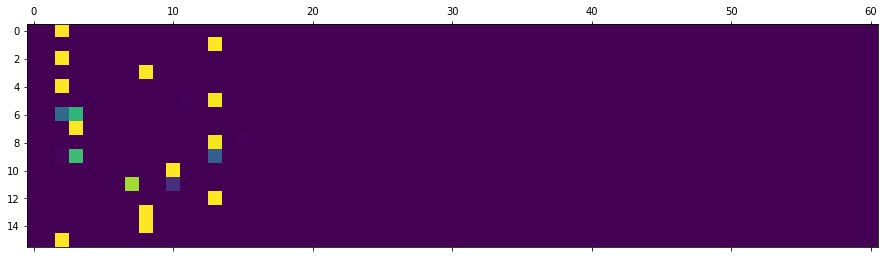

In [243]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "2013")
plt.matshow(attentions.numpy())

In [244]:
def plot_head_map(mma, target_labels, source_labels):
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(mma, cmap=plt.cm.Blues)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(mma.shape[1])+0.5, minor=False)
    ax.set_yticks(np.arange(mma.shape[0])+0.5, minor=False)

    # without this I get some extra columns rows
    # http://stackoverflow.com/questions/31601351/why-does-this-matplotlib-heatmap-have-an-extra-blank-column
    ax.set_xlim(0, len(source_labels)+2)
    ax.set_ylim(0, len(target_labels)+1)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # source words -> column labels
    ax.set_xticklabels(['']+list(source_labels), minor=False)
    # target words -> row labels
    ax.set_yticklabels(list(target_labels), minor=False)

    plt.yticks(rotation=90)
    plt.show()

input = 4 March 2014
output = the fourth of march twenty fourteen<EOS>
torch.Size([36, 61])


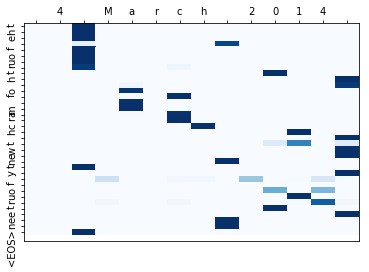

In [245]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ''.join(output_words))
    print(attentions.shape)
    plot_head_map(attentions,output_words,input_sentence)


evaluateAndShowAttention("4 March 2014")

input = 1982
output = nineteen eighty two<EOS>
torch.Size([20, 61])


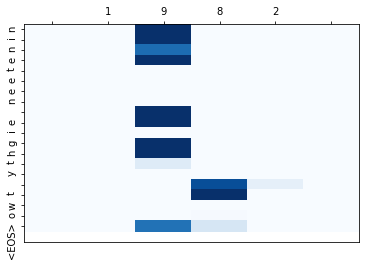

In [246]:
evaluateAndShowAttention("1982")

input = August 16, 2005
output = august sixteenth two thousand five<EOS>
torch.Size([35, 61])


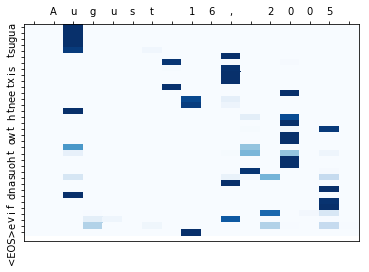

In [247]:
evaluateAndShowAttention("August 16, 2005")